In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import math
import numpy as np
from scipy.signal import detrend
import pywt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[2]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

print(src_path)

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

E:\vatecas\src


In [2]:
initial_time = pd.to_datetime('2023-01-01T12:00:00+00:00')
final_time = pd.Timestamp('2024-01-01T12:00:00+00:00')

In [3]:
tickers = ["SPY", "NVDA", "TSLA"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

<h1>Kalman</h1>

In [4]:
from signal_generator.regression.Kalman_filter import KalmanFilter
from signal_generator.regression.UKF_log import UKFlog
from signal_generator.regression.lag import Lag
from signal_generator.regression.VAR import VAROracle

from signal_generator.regression.base.oracle_diagnostics import oracle_diagnostics

kalman = KalmanFilter(process_noise=1e+3, obs_noise_scale=1e-3)
ukf_log = UKFlog(process_noise=1e-1, obs_noise_scale=1e-1)
lag = Lag(lag_days=1)
var = VAROracle(lag=5)

Lag Oracle is regressing: 100%|██████████| 210/210 [00:10<00:00, 19.71it/s]


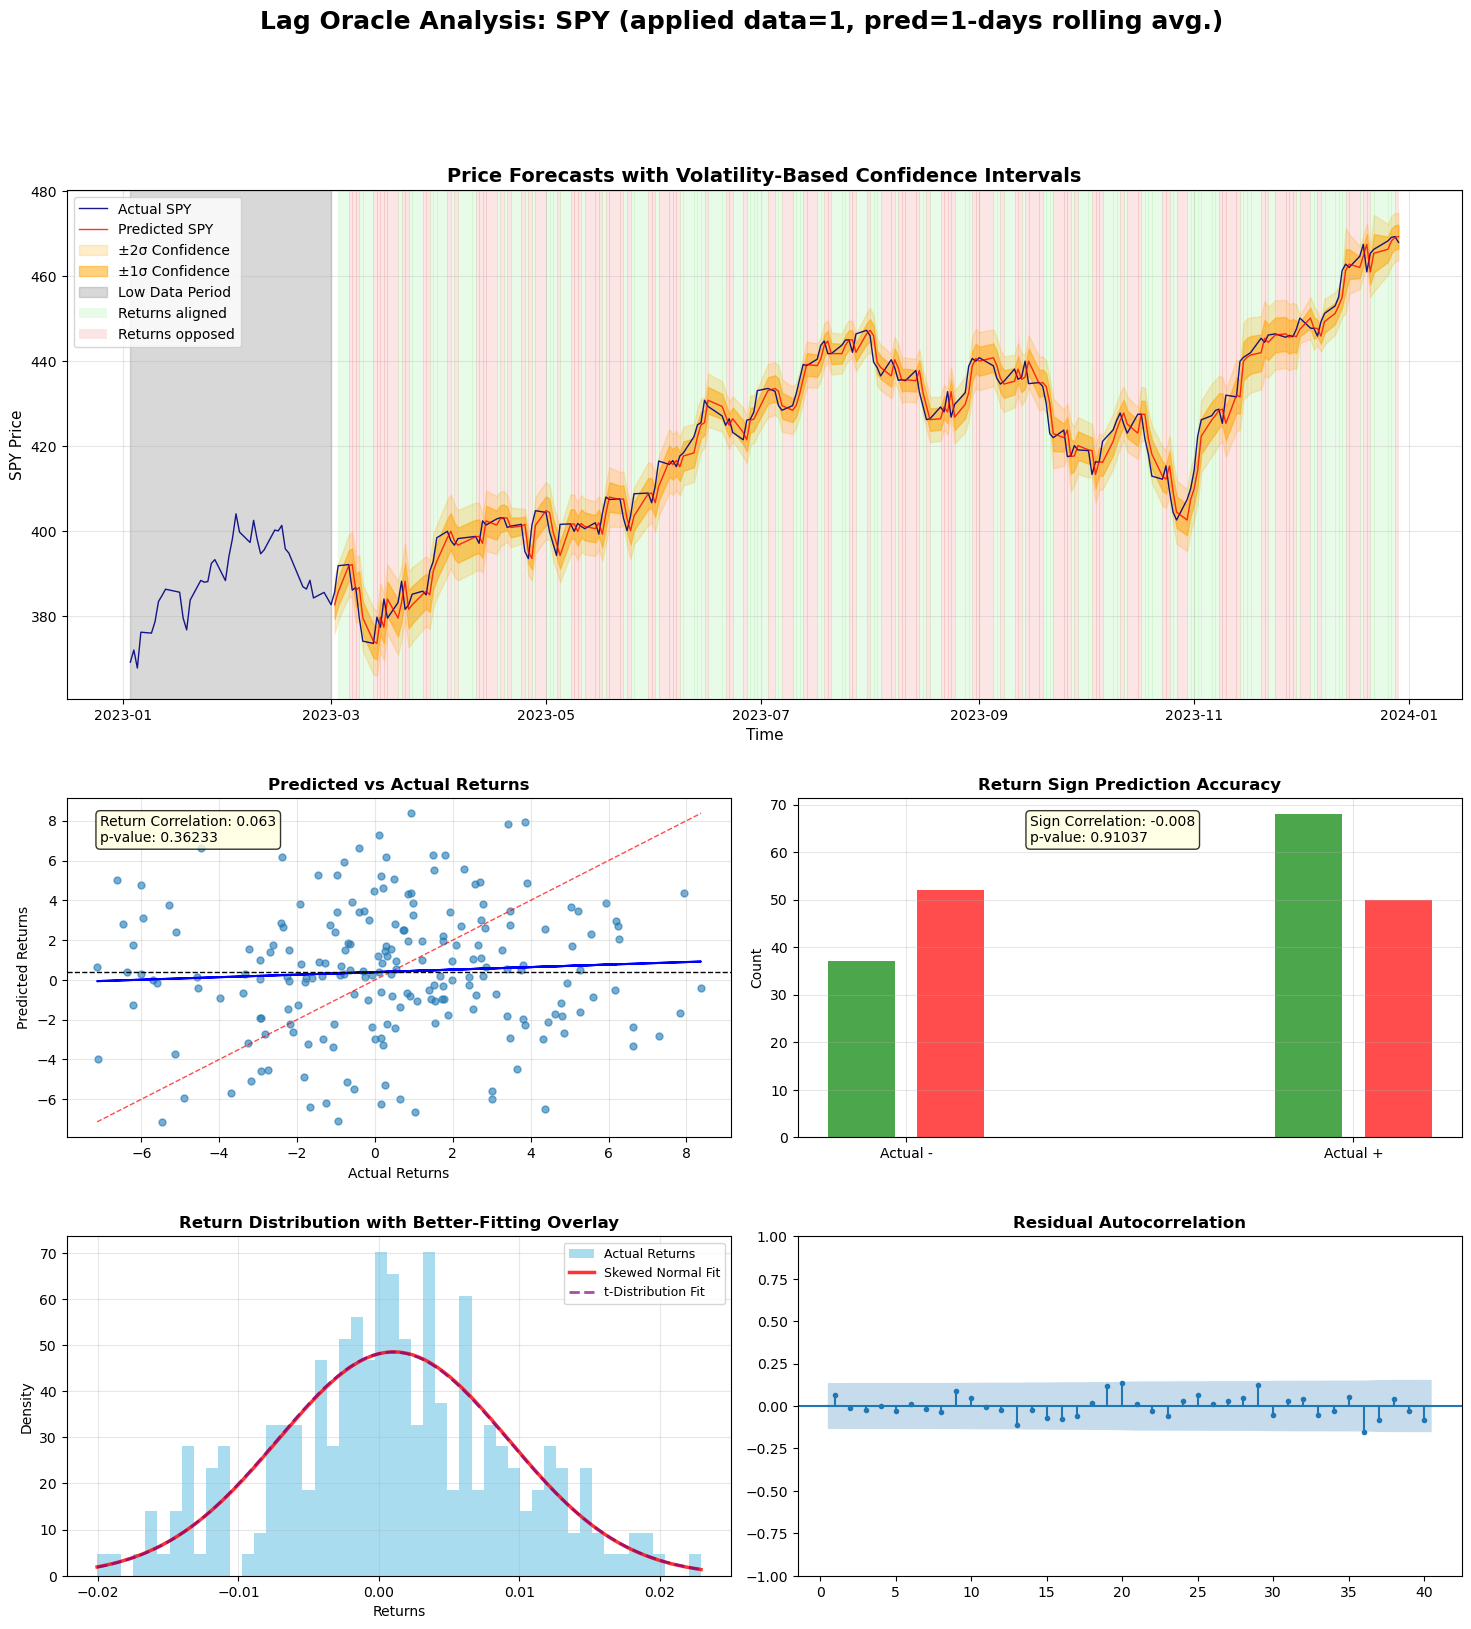

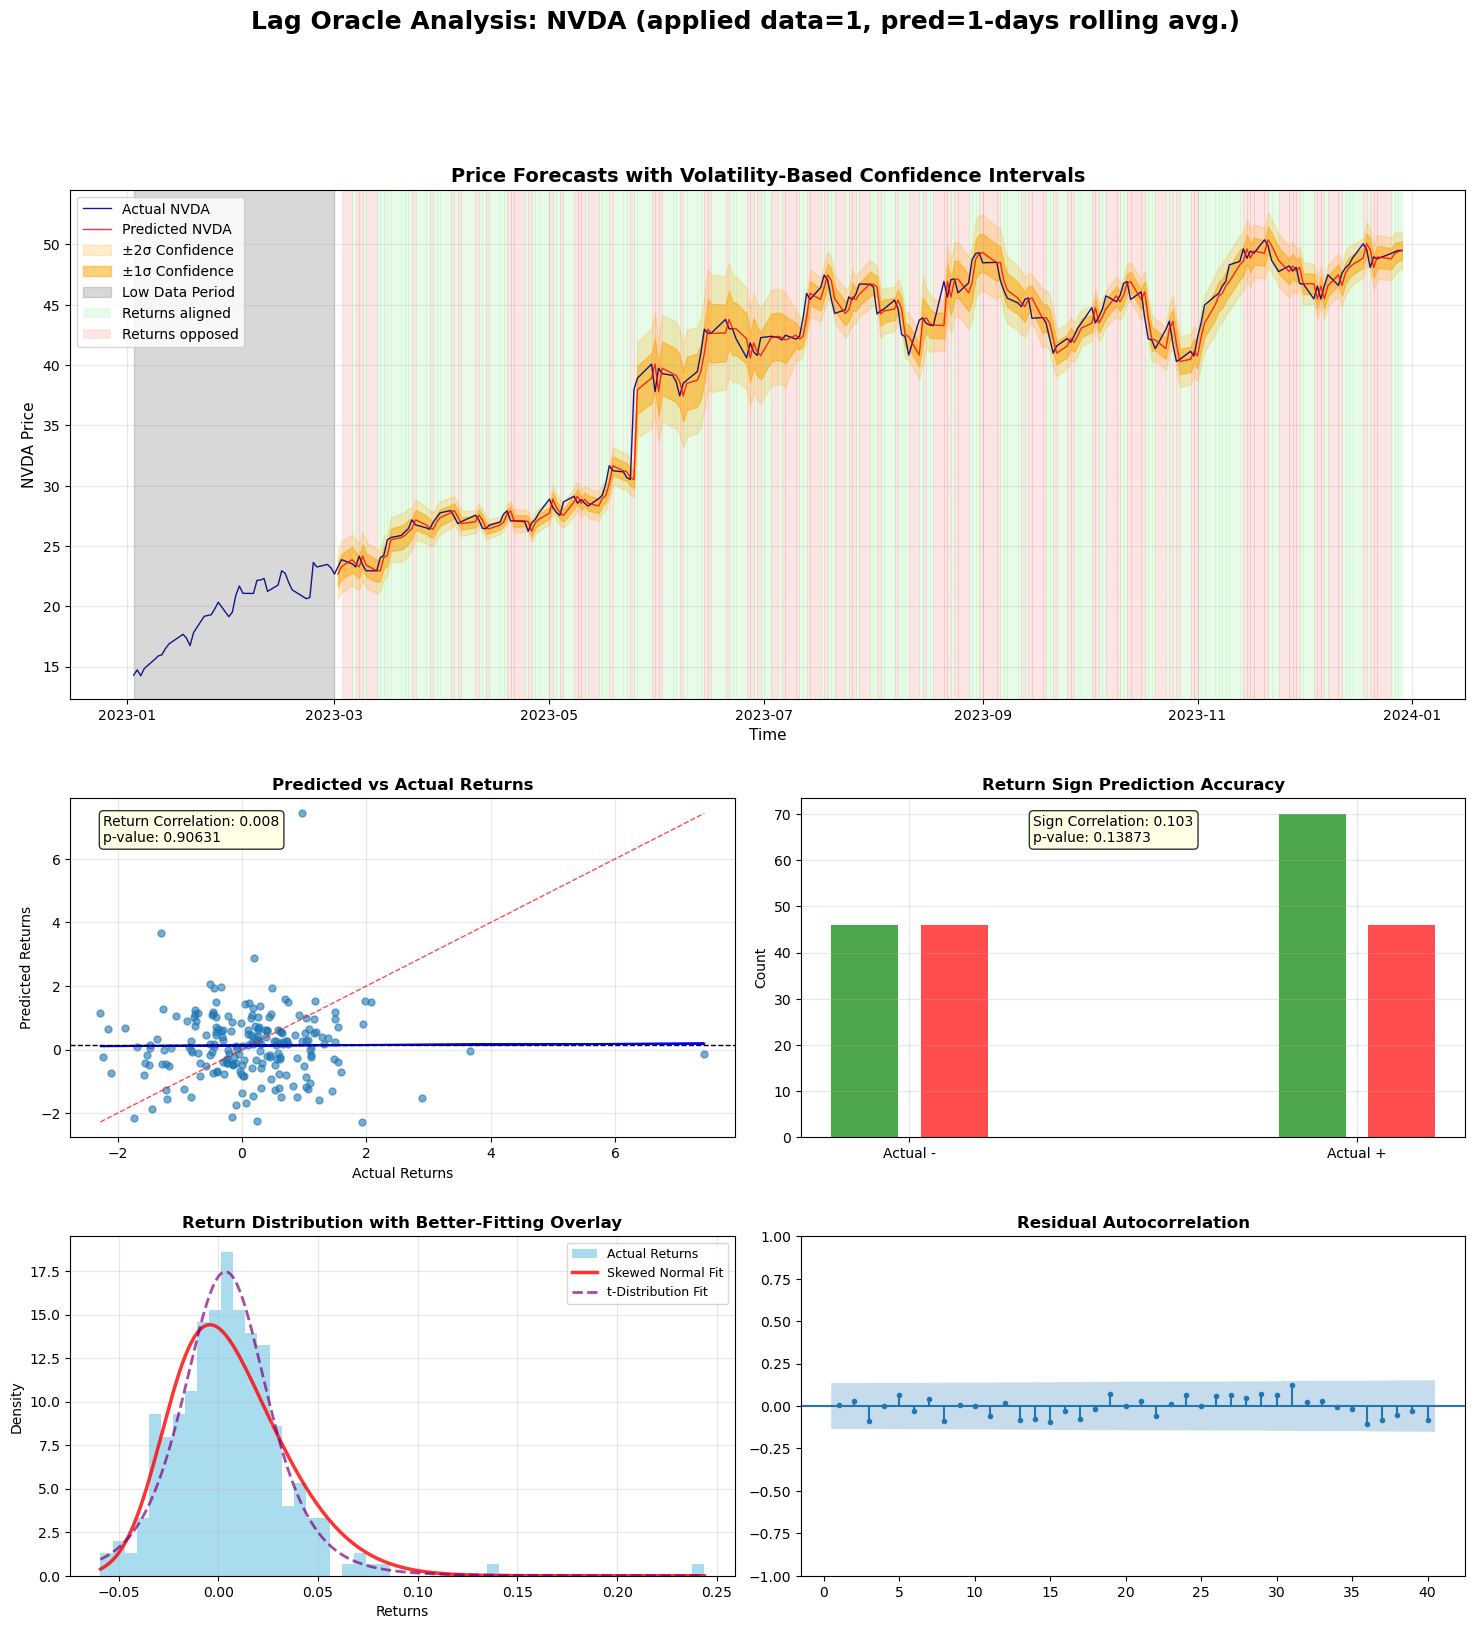

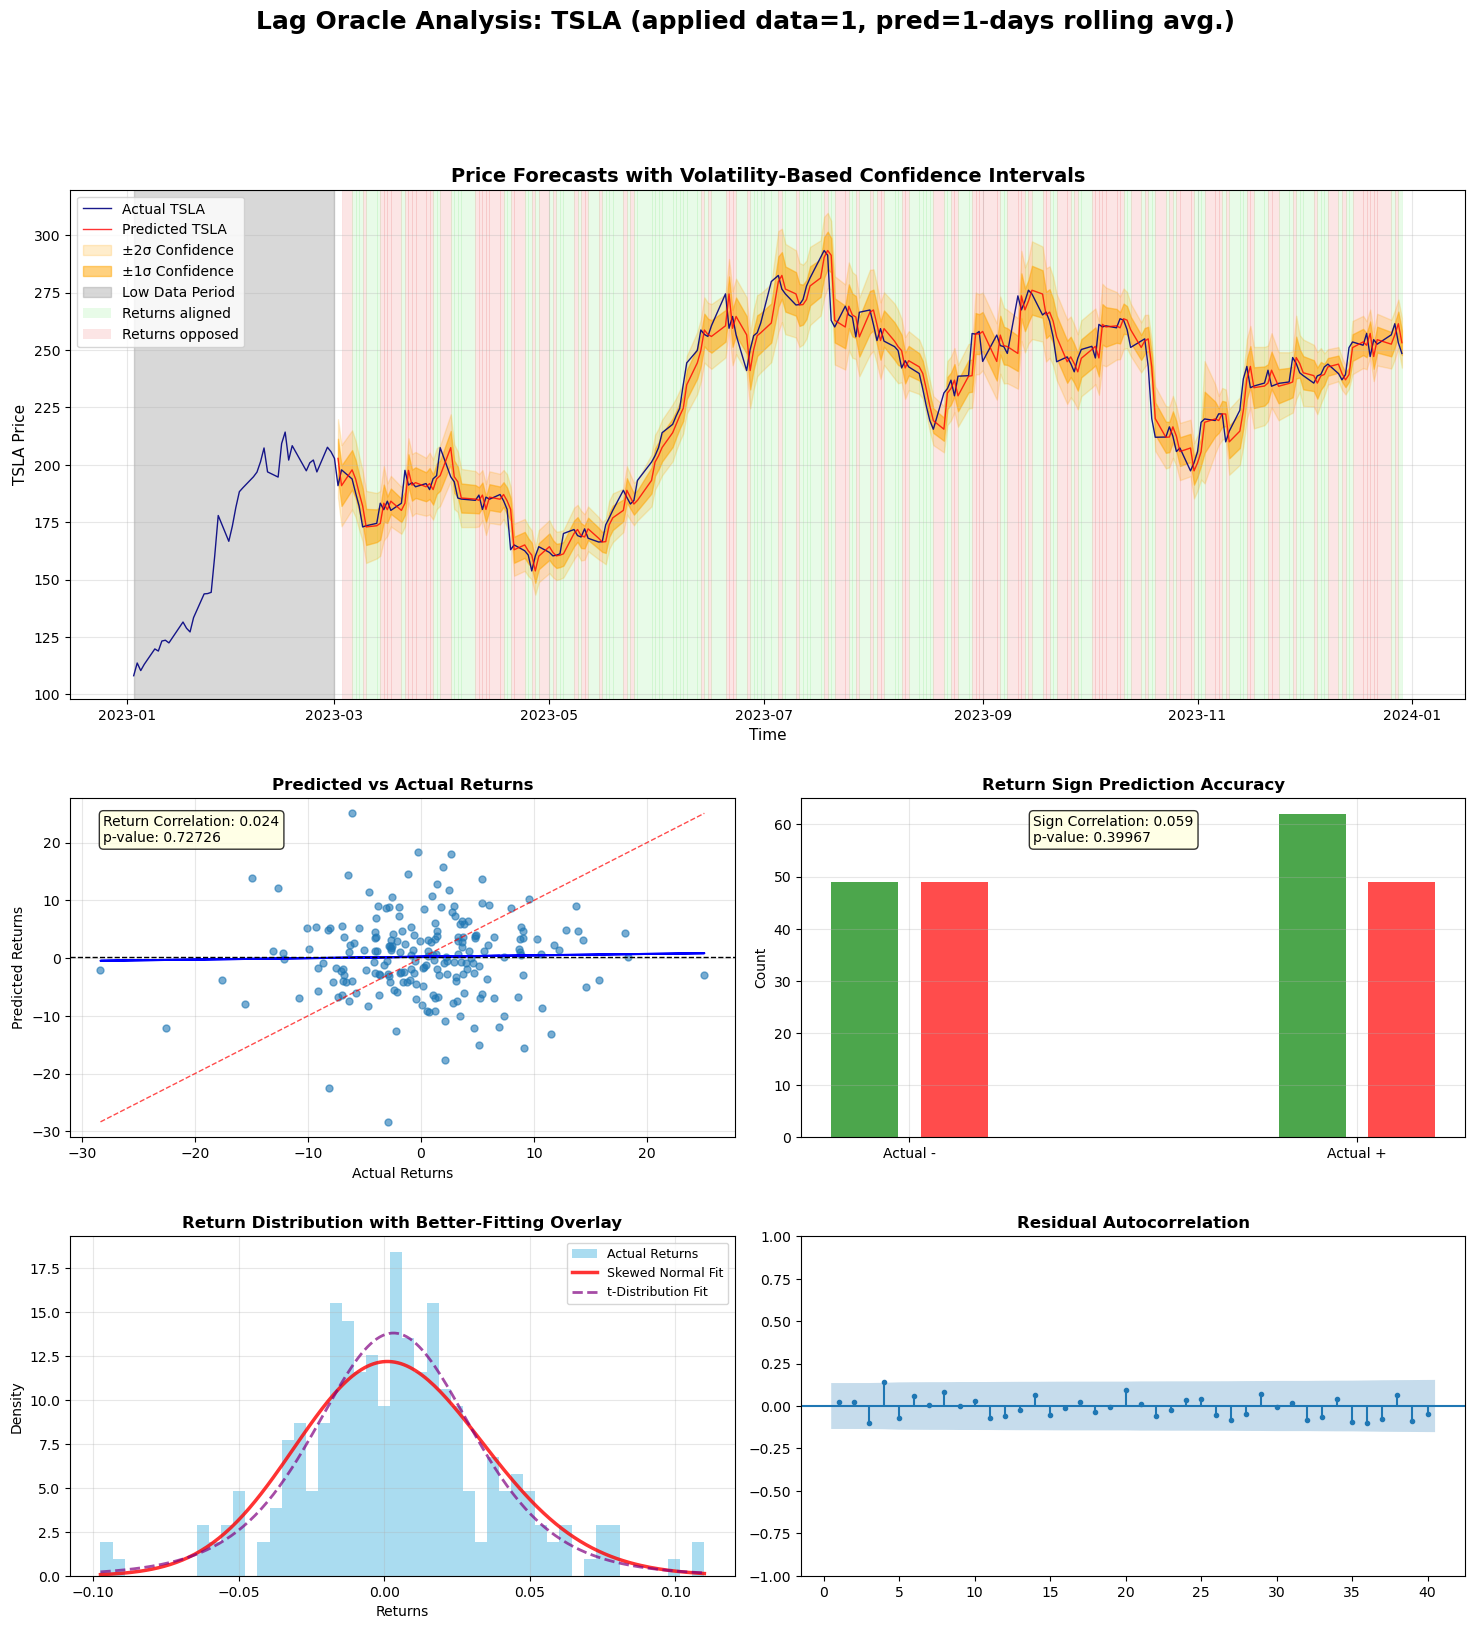

In [5]:
oracle_diagnostics(oracle=lag, data=closing_data, regress_window=40, smoothing_window_data=1, smoothing_window_pred=1)

<h1>Comparison with Synthetic data (pure noise)</h1>

In [6]:
from utils.synthetic import synthetic_data

In [7]:
fake_data = synthetic_data(200, 4, [100, 20, 50, 500], [2, .5, 3, 5])
fake_df = pd.DataFrame(fake_data)

In [8]:
#oracle_diagnostics(oracle=ukf_log, data=fake_data, regress_window=40, smoothing_window_data=1, smoothing_window_pred=1)